## <center>[Uma.Tech](https://uma.tech) – Data Competition</center>

This is a notebook for competition held by Uma.Tech. Our target is to determine customer churn rate - 'label' given incoming customer 'email'.

Before we get to the data, let's initialize our environment:

In [75]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

import gc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import shap

%matplotlib inline

from collections import Counter

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import category_encoders as ce

from bayes_opt import BayesianOptimization
import lightgbm as lgb
from lightgbm import LGBMClassifier

Some useful functions:

In [76]:
def Target_Encoder(Df_Train, Df_test, y_train, cat_features):
    """
    
    Target encoding the features with large number of values.
    
    """
    
    print('Target encoding...')
    
    oof = pd.DataFrame([])
    Df_Train.sort_index(inplace=True)   
    
    for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=17, shuffle=True).split(Df_Train, y_train):
        ce_target_encoder = ce.TargetEncoder(cols = cat_features, smoothing=100)
        ce_target_encoder.fit(Df_Train.iloc[tr_idx, :], y_train.iloc[tr_idx])
        oof = oof.append(ce_target_encoder.transform(Df_Train.iloc[oof_idx, :]), ignore_index=False)
    
    ce_target_encoder = ce.TargetEncoder(cols = cat_features, smoothing=100)
    ce_target_encoder.fit(Df_Train, y_train)
    Df_Train = oof.sort_index()
    Df_test = ce_target_encoder.transform(Df_test)
    
    print('Target encoding done!')
    
    return Df_Train, Df_test, y_train


def Frequency_Encoder(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values


def Label_Encoder(df_train, df_test, features):
    
    label_encoders = [LabelEncoder() for _ in range(len(features)+1)]

    for col, column in enumerate(features):
        unique_values = pd.Series(df_train[column].append(df_test[column]).unique())
        unique_values = unique_values[unique_values.notnull()]
        label_encoders[col].fit(unique_values)
        df_train.loc[df_train[column].notnull(), column] = label_encoders[col].transform(
            df_train.loc[df_train[column].notnull(), column])
        df_test.loc[df_test[column].notnull(), column] = label_encoders[col].transform(
            df_test.loc[df_test[column].notnull(), column])
    
    return df_train, df_test

def Create_Datetime_Features(df, feature):
    """
    
    Creates datetime features from specified columns
    
    """

    for i in feature:
        df[i] = pd.to_datetime(df[i], errors='raise')
        df['dayofmonth_{}'.format(i)] = df.eval(i).dt.day
        df['dayofweek_{}'.format(i)] = df.eval(i).dt.dayofweek
        df['month_{}'.format(i)] = df.eval(i).dt.month
        
    return df

In [77]:
def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    
    folds = GroupKFold(n_splits=NFOLDS)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  
    split_groups = tr_df['DT_M']

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    oof = np.zeros(len(tr_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS
        
        oof_preds = estimator.predict(vl_x)
        oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    print('OOF AUC:', metrics.roc_auc_score(y, oof))
    if LOCAL_TEST:
        print('Holdout AUC:', metrics.roc_auc_score(tt_df[TARGET], tt_df['prediction']))
    
    return tt_df

In [4]:
os.chdir('input')
cwd = os.getcwd()

In [112]:
train = pd.read_csv(cwd + '\\TRAIN_PREPARED.csv')
test = pd.read_csv(cwd + '\\TEST_PREPARED.csv')
train_add = pd.read_csv(cwd + '\\TRAIN_ADDITIONAL_DATA.csv')
test_add = pd.read_csv(cwd + '\\TEST_ADDITIONAL_DATA.csv')
submit = pd.read_csv(cwd + '\\test_submit_example.csv')

## 1. Dataset
We have two data sources, lets see their structure:

In [6]:
train.head()

cut_date  days_to_end       email           first_date  \
0  2019-04-02 00:00:00           11  8ba752f2c5  2019-02-10 00:00:00   
1  2019-04-02 00:00:00           10  752a6d96f7  2018-10-28 00:00:00   
2  2019-04-02 00:00:00            4  827f6afef3  2018-12-14 00:00:00   
3  2019-04-02 00:00:00            9  346e0f766c  2019-03-08 00:00:00   
4  2019-04-02 00:00:00           10  0addbcc79a  2019-01-09 00:00:00   

             last_date  num_country_max_1days  num_city_max_1days  \
0  2019-03-13 09:36:59                    0.0                 0.0   
1  2019-04-01 20:51:29                    0.0                 0.0   
2  2019-04-01 18:00:49                    0.0                 0.0   
3  2019-03-31 23:05:17                    0.0                 0.0   
4  2019-03-25 17:41:09                    0.0                 0.0   

   android_max_1days  smarttv_max_1days  iphone_max_1days  ...  \
0                0.0                0.0               0.0  ...   
1                0.0                0.0               0.0  ...   
2                0.0                0.0               0.0  ...   
3                0.0                0.0               0.0  ...   
4                0.0                0.0               0.0  ...   

   apple_max_30days  pc_max_30days  activity_1to3  activity_1to7  \
0               0.0            0.0            0.0            0.0   
1               0.0            4.0            0.0            0.0   
2               0.0            6.0            0.0            0.0   
3               0.0            6.0            0.0            0.0   
4               0.0            6.0            0.0            0.0   

   activity_1to14  activity_7to14  activity_7to21  activity_7to30  \
0             0.0        0.000000        0.000000        0.000000   
1             0.0        0.005807        0.005774        0.003030   
2             0.0        0.937031        0.832238        0.598121   
3             0.0        0.540452        0.536714        0.316218   
4             0.0        0.000000        0.000000        0.000000   

   activity_14to30  label  
0         0.000000    0.0  
1         0.521792    1.0  
2         0.638308    0.0  
3         0.585099    1.0  
4         0.418660    0.0  

[5 rows x 146 columns]

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180249 entries, 0 to 180248
Columns: 146 entries, cut_date to label
dtypes: float64(141), int64(1), object(4)
memory usage: 200.8+ MB


In [8]:
train.columns.values

array(['cut_date', 'days_to_end', 'email', 'first_date', 'last_date',
       'num_country_max_1days', 'num_city_max_1days', 'android_max_1days',
       'smarttv_max_1days', 'iphone_max_1days', 'ipad_max_1days',
       'apple_max_1days', 'pc_max_1days', 'time_spent_sum_3days',
       'time_spent_max_3days', 'num_title_ep_sum_3days',
       'num_title_ep_max_3days', 'num_title_ru_sum_3days',
       'num_title_ru_max_3days', 'num_country_max_3days',
       'num_city_max_3days', 'other_content_sum_3days', 'top_1_sum_3days',
       'top_2_sum_3days', 'top_3_sum_3days', 'top_4_sum_3days',
       'top_5_sum_3days', 'top_6_sum_3days', 'top_7_sum_3days',
       'top_8_sum_3days', 'top_9_sum_3days', 'top_10_sum_3days',
       'android_max_3days', 'smarttv_max_3days', 'iphone_max_3days',
       'ipad_max_3days', 'apple_max_3days', 'pc_max_3days',
       'time_spent_sum_7days', 'time_spent_max_7days',
       'num_title_ep_sum_7days', 'num_title_ep_max_7days',
       'num_title_ru_sum_7days', 'num_

We can find out from names that our features must correlated.

In [11]:
train.dtypes

cut_date            object
days_to_end          int64
email               object
first_date          object
last_date           object
                    ...   
activity_7to14     float64
activity_7to21     float64
activity_7to30     float64
activity_14to30    float64
label              float64
Length: 146, dtype: object

In [207]:
train_add.head()

action       email  trial                   calday
0  DELETE  9007366702    NaN  2018-10-26 03:26:41.607
1  CREATE  ad49ae7b1d  False  2018-12-01 18:16:56.971
2  CREATE  2165677f19  False  2018-12-01 18:16:58.380
3  CREATE  13ded413c2  False  2018-12-01 18:16:58.444
4  CREATE  032adbb404  False  2018-12-01 18:16:59.568

In [208]:
train_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43494 entries, 0 to 43493
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   action  43494 non-null  object
 1   email   43494 non-null  object
 2   trial   43295 non-null  object
 3   calday  43494 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


Lets check our data for null-values:

In [90]:
(train.isnull().any().any(), test.isnull().any().any(), 
 train_add.isnull().any().any(), test_add.isnull().any().any())

(False, False, True, True)

There are some! And they turned out to be in 'trial' feature:

In [90]:
(train_add['trial'].isnull().any(), test_add['trial'].isnull().any(), 
 train_add['trial'].isnull().sum().sum(), test_add['trial'].isnull().sum().sum())

(True, True, 199, 82)

We will fill them with false, assuming this was database input error:

In [113]:
train_add['trial'] = train_add['trial'].fillna(False)
test_add['trial'] = test_add['trial'].fillna(False)

Next we will see, if there are any users who performed multiple actions:

In [253]:
pd.concat(g for _, g in train_add.groupby("email") if len(g) > 1).head(10)

action       email  trial                   calday
28131  DELETE  00012a0ea1  False  2019-03-05 06:45:24.828
29763  CREATE  00012a0ea1  False  2019-03-10 12:51:55.085
38321  CREATE  001014e9a8   True  2019-03-31 21:33:27.654
38963  DELETE  001014e9a8   True  2019-04-04 09:31:44.212
41438  CREATE  001014e9a8   True  2019-04-12 07:21:26.807
41439  DELETE  001014e9a8   True  2019-04-12 07:22:27.040
3528   CREATE  001673d7cf   True  2018-12-08 22:03:00.216
41476  DELETE  001673d7cf  False  2019-04-12 09:03:27.026
6400   DELETE  0019ad2531  False  2018-12-16 07:55:56.458
24646  CREATE  0019ad2531  False  2019-02-21 16:21:11.085

It turns out there are, which can allow us to produce interesting features out of it.

## 2. visualization & feature engineering
First, we will check 'label' and feature distribution. As many of our features havily correlated, we will check sums and max values. 

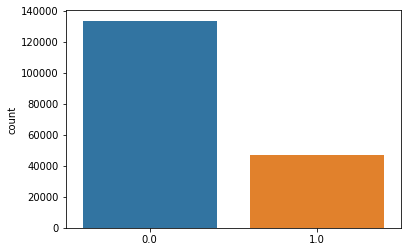

In [70]:
sns.countplot(x = train['label'].values);

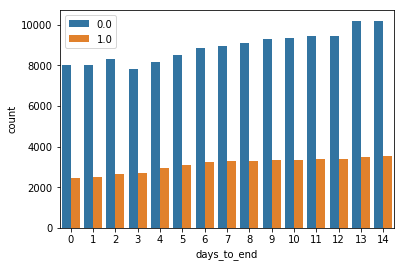

In [71]:
sns.countplot(x = train['days_to_end'], hue = train['label'].values);

In [114]:
activity_cols = [i for i in train.columns.values if 'activity' in i]
sum_cols = [i for i in train.columns.values if 'sum_30days' in i]
max_cols = [i for i in train.columns.values if 'max_30days' in i]

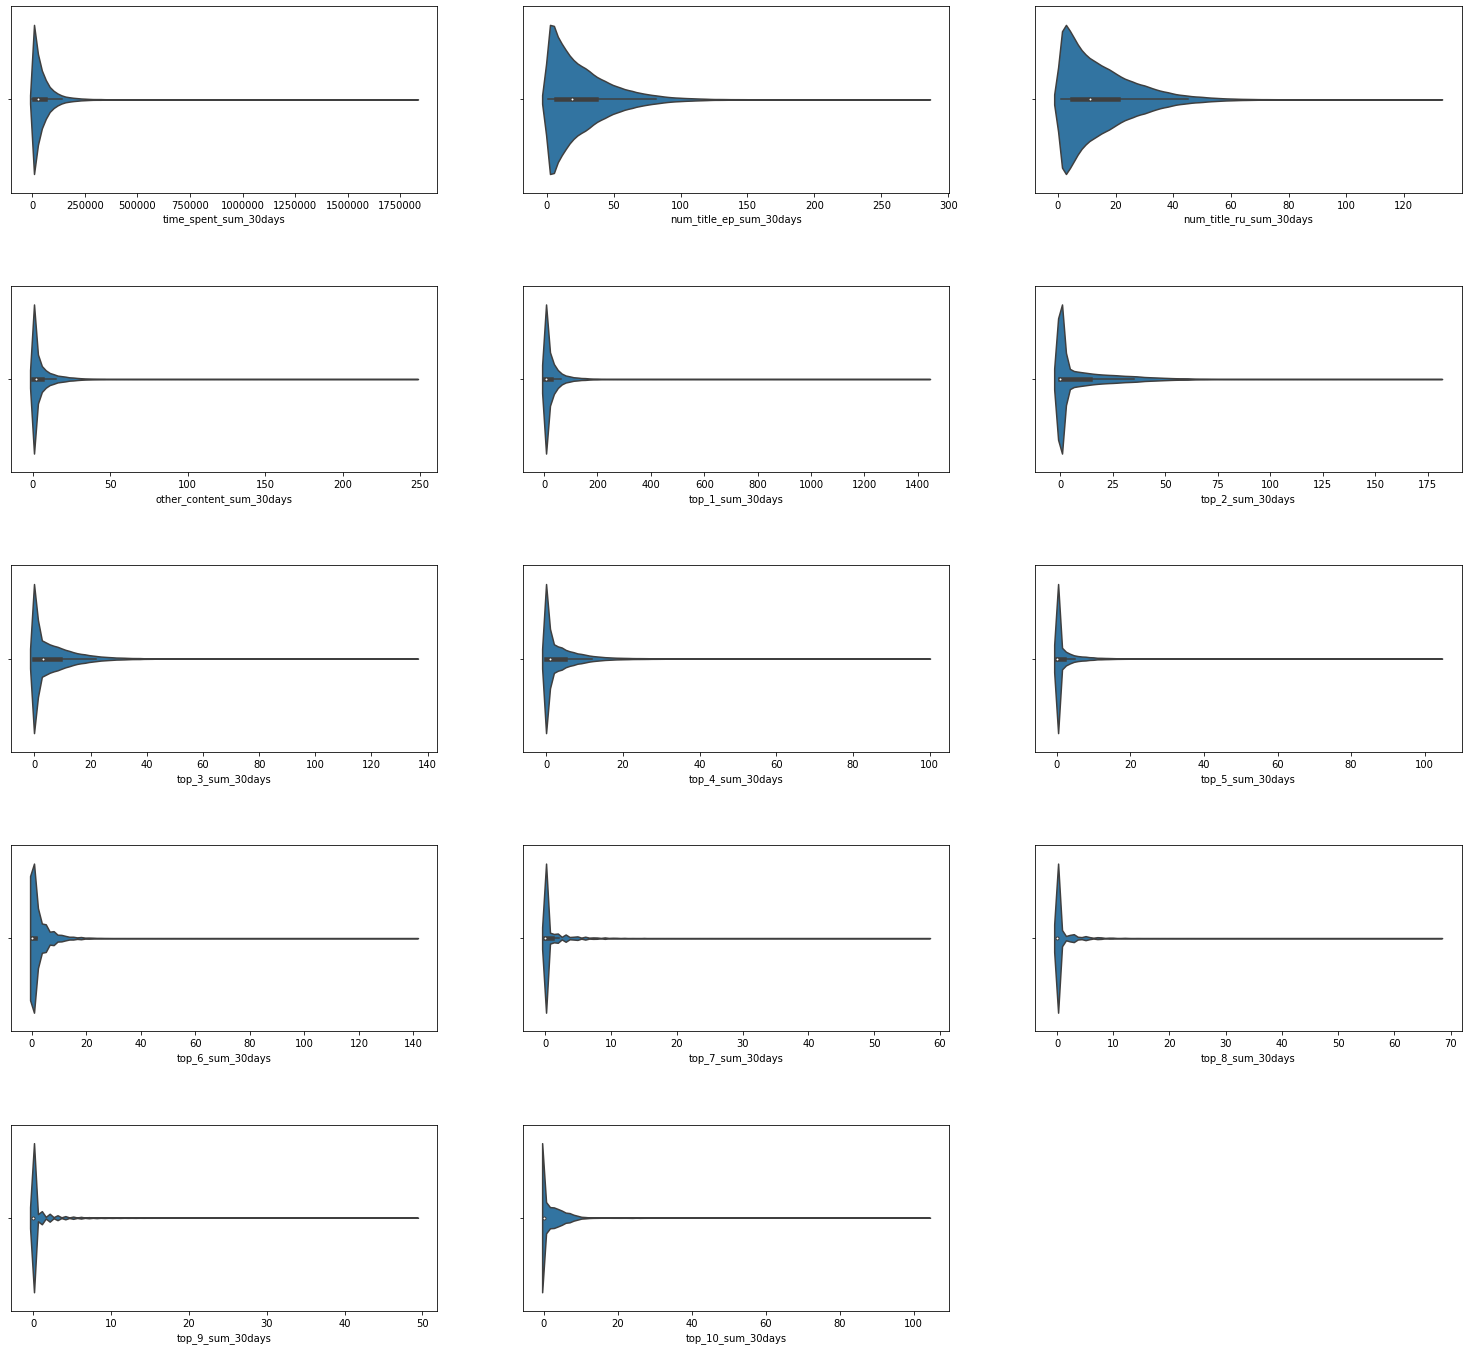

In [246]:
figure = plt.figure(figsize=(26, 24))
for i, col in enumerate(sum_cols):
    plt.subplot(5, 3, i + 1)
    figure.subplots_adjust(hspace=0.5)
    sns.violinplot(train[col])

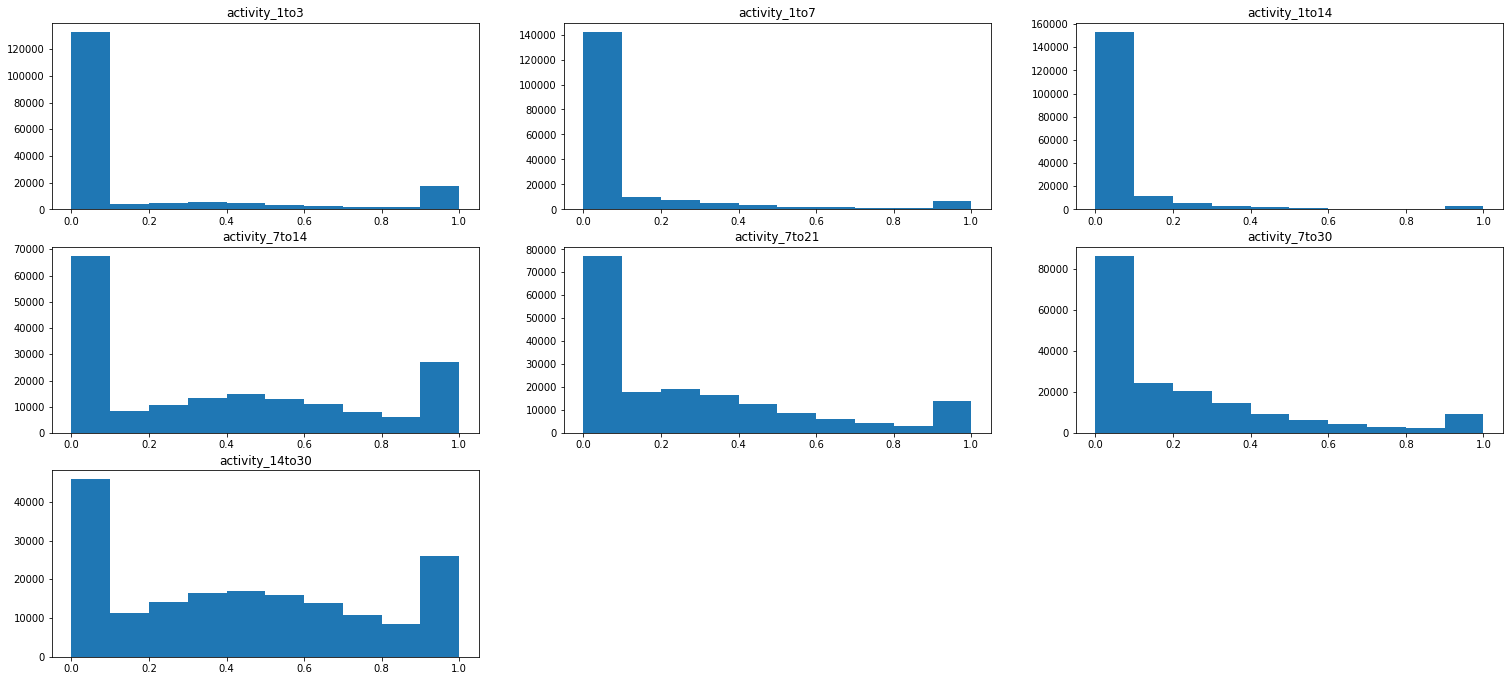

In [8]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(activity_cols):
    plt.subplot(6, 3, i + 1)
    plt.hist(train[col])
    plt.title(col)

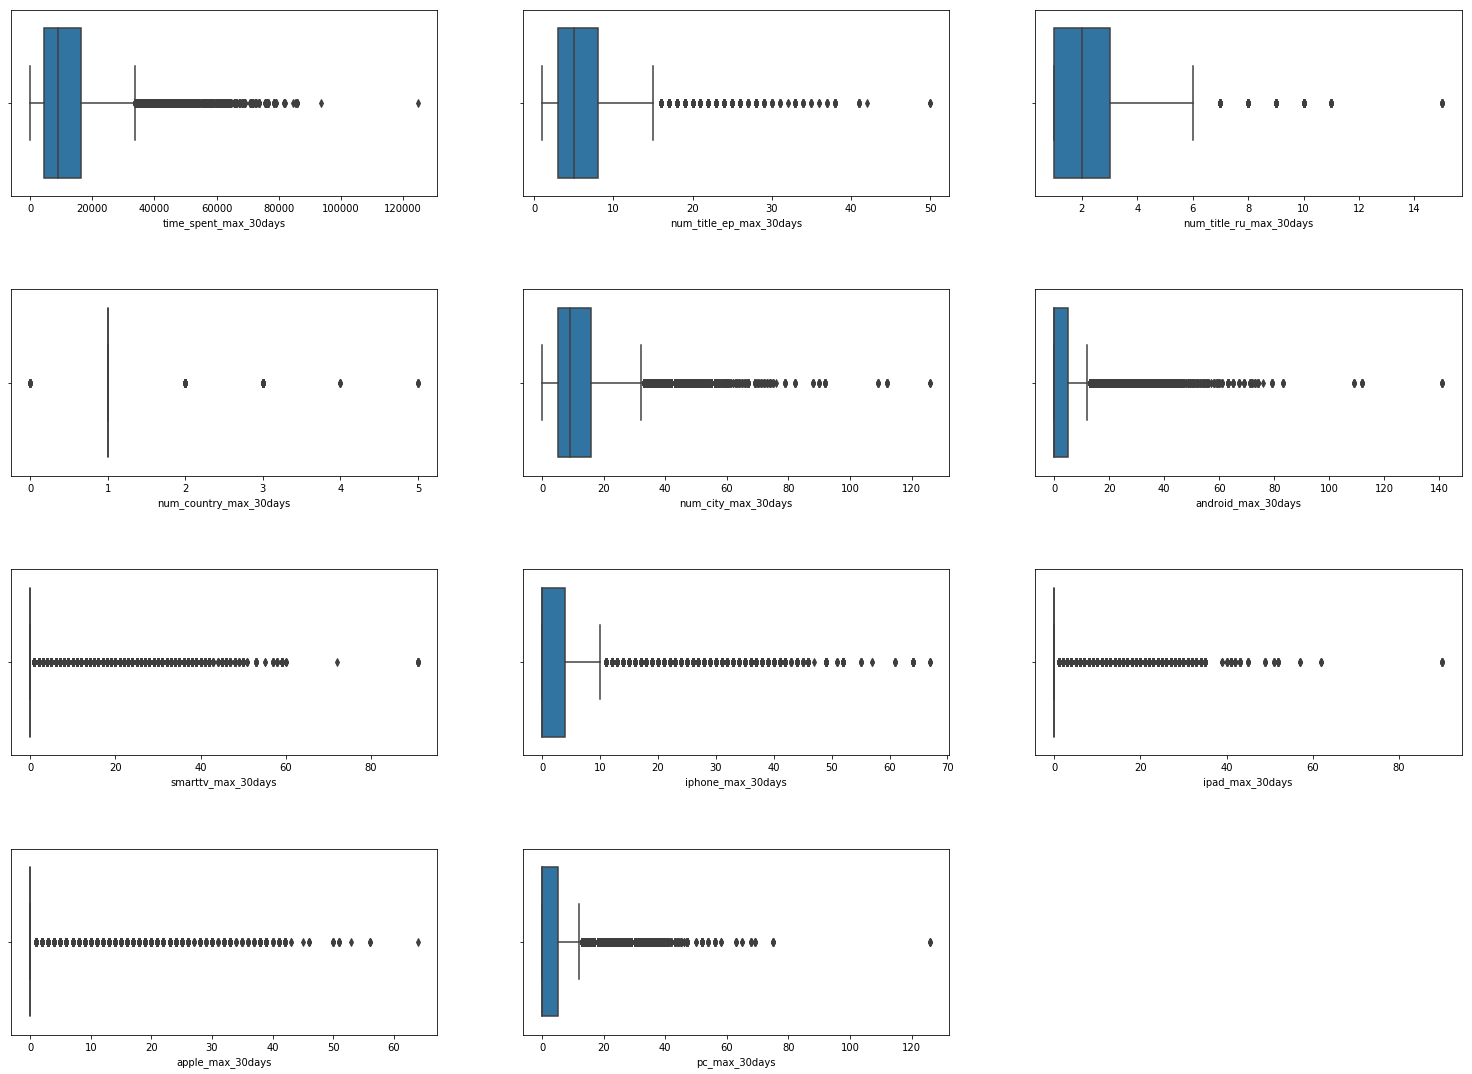

In [75]:
figure = plt.figure(figsize=(26, 24))
for i, col in enumerate(max_cols):
    plt.subplot(5, 3, i + 1)
    figure.subplots_adjust(hspace=0.5)
    sns.boxplot(train[col])

As we can see there are a lot of outliners in our data. Lets create some datetime features according to given data. 

In [228]:
y = train['label']
X_train, X_test = train, test
X_train_add, X_test_add = train_add, test_add

We'll explore relation between date and our data, so we can create some additional features using second dataset.<br>
But before that, lets take a look into second dataset:

In [35]:
X_train_add.head()

action       email  trial                   calday
0  DELETE  9007366702  False  2018-10-26 03:26:41.607
1  CREATE  ad49ae7b1d  False  2018-12-01 18:16:56.971
2  CREATE  2165677f19  False  2018-12-01 18:16:58.380
3  CREATE  13ded413c2  False  2018-12-01 18:16:58.444
4  CREATE  032adbb404  False  2018-12-01 18:16:59.568

Lets take a look at the last actions performed by customers and create some features based on that:

In [234]:
X_train_add_actions = X_train_add.drop_duplicates(subset='email', keep="last")
last_train_action = X_train_add_actions.set_index('email')['action'].to_dict()
last_train_trial = X_train_add_actions.set_index('email')['trial'].to_dict()
X_train_add_actions['calday'] = pd.to_datetime(X_train_add_actions['calday']).dt.date
last_train_date = X_train_add_actions.set_index('email')['calday'].to_dict()

In [235]:
X_test_add_actions = X_test_add.drop_duplicates(subset='email', keep="last")
last_test_action = X_test_add_actions.set_index('email')['action'].to_dict()
last_test_trial = X_test_add_actions.set_index('email')['trial'].to_dict()
X_test_add_actions['calday'] = pd.to_datetime(X_test_add_actions['calday']).dt.date
last_test_date = X_test_add_actions.set_index('email')['calday'].to_dict()

In [236]:
X_train_add_actions = X_train_add.drop_duplicates(subset='email', keep="last")
X_train_add_actions = X_train_add_actions[(X_train_add_actions['action'] == 'DELETE') &
                                         (X_train_add_actions['trial'] == False)]
last_delete_trial_false_train = X_train_add_actions.set_index('email')['action'].to_dict()

In [237]:
X_train_add_actions = X_train_add.drop_duplicates(subset='email', keep="last")
X_train_add_actions = X_train_add_actions[(X_train_add_actions['action'] == 'CREATE') &
                                         (X_train_add_actions['trial'] == True)]
last_create_trial_true_train = X_train_add_actions.set_index('email')['action'].to_dict()

In [238]:
X_test_add_actions = X_test_add.drop_duplicates(subset='email', keep="last")
X_test_add_actions = X_test_add_actions[(X_test_add_actions['action'] == 'DELETE') &
                                         (X_test_add_actions['trial'] == False)]
last_delete_trial_false_test = X_test_add_actions.set_index('email')['action'].to_dict()

In [239]:
X_test_add_actions = X_test_add.drop_duplicates(subset='email', keep="last")
X_test_add_actions = X_test_add_actions[(X_test_add_actions['action'] == 'CREATE') &
                                         (X_test_add_actions['trial'] == True)]
last_create_trial_true_test = X_test_add_actions.set_index('email')['action'].to_dict()

In [240]:
Trials = X_train_add[X_train_add['trial'] == True]['email'].unique()
Trials = {k:1 for k in Trials}

In [241]:
X_train['used_trial'] = X_train['email'].map(Trials).fillna(0)
X_test['used_trial'] = X_test['email'].map(Trials).fillna(0)

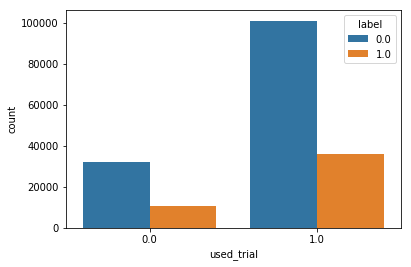

In [79]:
sns.countplot(x = X_train['used_trial'], hue = y);

It doesn't seem that there are more churned users who didn't use trial.

In [242]:
Actions_train = X_train_add['email'].value_counts().to_dict()
Actions_test = X_test_add['email'].value_counts().to_dict()

In [243]:
X_train['actions'] = X_train['email'].map(Actions_train).fillna(0)
X_test['actions'] = X_test['email'].map(Actions_test).fillna(0)

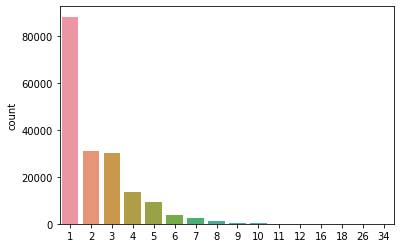

In [19]:
sns.countplot(x = X_train['actions'].values);

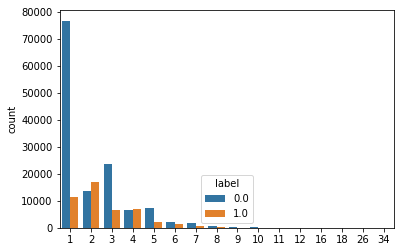

In [83]:
sns.countplot(x = X_train['actions'].values, hue = y);  

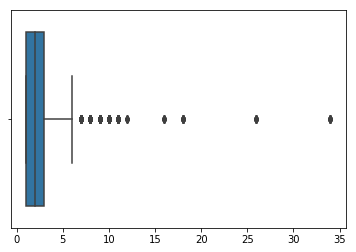

In [84]:
sns.boxplot(x = X_train['actions'].values, hue = y);  

Bingo! There is definitely something going on with the users who had to perform 2, 4 and 6 actions, lets add these features:

In [244]:
for i in range(2, 8, 2):
    X_train['actions_{}'.format(i)] = (X_train['actions'] == i).map({True: 1, False: 0})
    X_test['actions_{}'.format(i)] = (X_test['actions'] == i).map({True: 1, False: 0})

Now we'll see if customer last actions had any correlation with churn rate:

In [245]:
X_train['last_action'] = X_train['email'].map(last_train_action).map({'CREATE': 1, 'DELETE': 0})
X_train['last_trial'] = X_train['email'].map(last_train_trial).map({True: 1, False: 0})
X_train['last_action_date'] = X_train['email'].map(last_train_date)
X_train['last_delete_trial_false'] = X_train['email'].map(last_delete_trial_false_train).map({'DELETE': 1, np.nan: 0})
X_train['last_create_trial_true'] = X_train['email'].map(last_create_trial_true_train).map({'CREATE': 1, np.nan: 0})
X_test['last_action'] = X_test['email'].map(last_test_action).map({'CREATE': 1, 'DELETE': 0})
X_test['last_trial'] = X_test['email'].map(last_test_trial).map({True: 1, False: 0})
X_test['last_action_date'] = X_test['email'].map(last_test_date)
X_test['last_delete_trial_false'] = X_test['email'].map(last_delete_trial_false_test).map({'DELETE': 1, np.nan: 0})
X_test['last_create_trial_true'] = X_test['email'].map(last_create_trial_true_test).map({'CREATE': 1, np.nan: 0})

In [251]:
gc.collect()

120

In [252]:
X_train = Create_Datetime_Features(X_train, ['first_date', 'last_date', 'last_action_date'])
X_test = Create_Datetime_Features(X_test, ['first_date', 'last_date', 'last_action_date'])

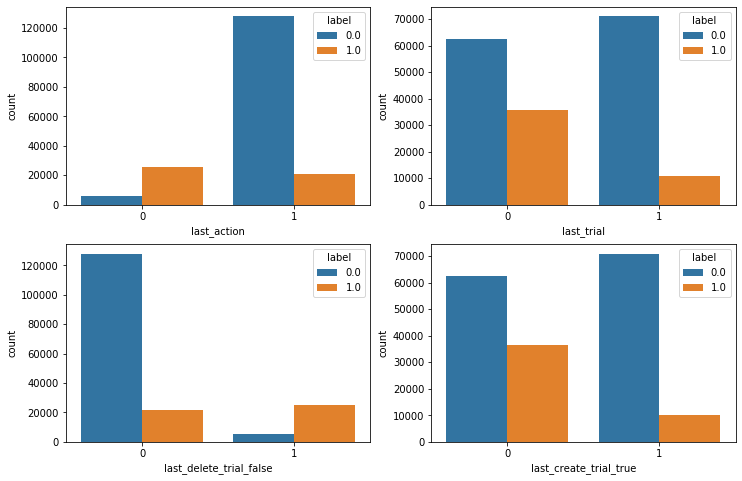

In [92]:
last_events = ['last_action', 'last_trial', 'last_delete_trial_false', 'last_create_trial_true']

figure = plt.figure(figsize=(12, 8))
for i, col in enumerate(last_events):
    plt.subplot(2, 2, i + 1)
    sns.countplot(X_train[col], hue = y);

We can see that a lot of churns turn out to have DELETE as the last action, along with False flag for trial.

In [129]:
datetime = ['cut_date', 'first_date', 'last_date']

for i in datetime:
    X_train[i] = pd.to_datetime(X_train[i]).dt.date
    X_test[i] = pd.to_datetime(X_test[i]).dt.date
    
X_train['days_total'] = (X_train['last_date'] - X_train['first_date']).dt.days.astype(int)
X_test['days_total'] = (X_test['last_date'] - X_test['first_date']).dt.days.astype(int)
X_train['months_total'] = ((X_train['last_date'] - X_train['first_date'])/np.timedelta64(1, 'M')).astype(int)
X_test['months_total'] = ((X_test['last_date'] - X_test['first_date'])/np.timedelta64(1, 'M')).astype(int)

In [130]:
X_time = X_train.sort_values(['first_date', 'last_date', 'last_action_date'], ascending=True)

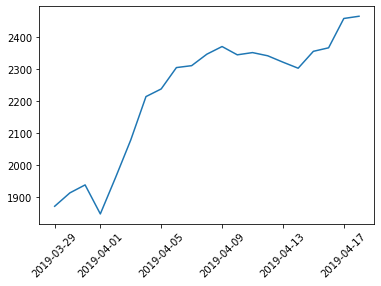

In [79]:
Cut_date = X_time[['cut_date', 'label']].groupby('cut_date').sum()
plt.plot(Cut_date)
plt.xticks(rotation=45);

We observe more churns going into further dates.

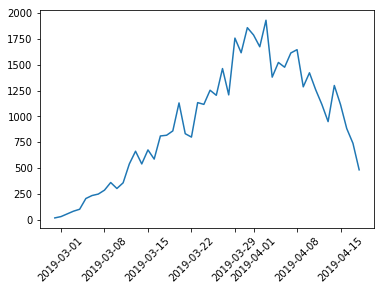

In [89]:
Last_date = X_time[['last_date', 'label']].groupby('last_date').sum()
plt.plot(Last_date)
plt.xticks(rotation=45);

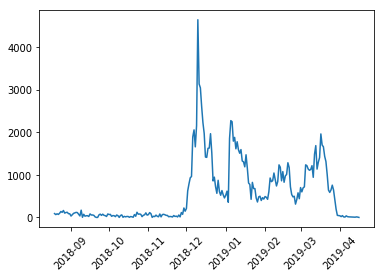

In [90]:
First_date = X_time[['first_date', 'used_trial']].groupby('first_date').sum()
plt.plot(First_date)
plt.xticks(rotation=45);

Some interesting obervations for speculation. Peopel started actively using trial starting from 2018.12.<br> 
It might be effect of marketing campaign as well as media presense.

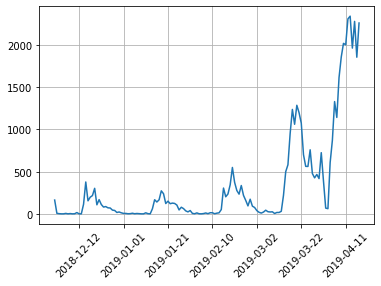

In [46]:
Total_days = X_time[['last_action_date', 'label']].groupby('last_action_date').sum()
fig, ax = plt.subplots()
ax.plot(Total_days)
loc = ticker.MultipleLocator(base=20)
ax.xaxis.set_major_locator(loc)
plt.grid()
plt.xticks(rotation=45);
plt.show();

We can observe very high churn rates after 2019-04. Lets add this as feature:

In [253]:
X_train['used_14to20_days'] = (X_train['last_action_date'] > '2019-04-01').map({True: 1, False: 0})
X_test['used_14to20_days'] = (X_test['last_action_date'] > '2019-04-01').map({True: 1, False: 0})

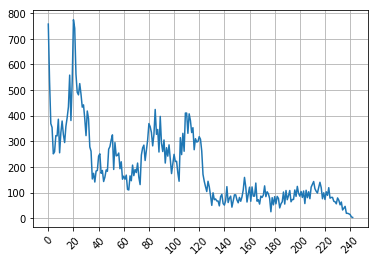

In [167]:
Total_days = X_time[['days_total', 'label']].groupby('days_total').sum()
fig, ax = plt.subplots()
ax.plot(Total_days)
loc = ticker.MultipleLocator(base=20)
ax.xaxis.set_major_locator(loc)
plt.grid()
plt.xticks(rotation=45);
plt.show();

In [168]:
Total_days.idxmax(axis = 0) 

label    20
dtype: int64

We can obeserve high churn rate at 20 days of usage. Possible end of trial? Lets add another set of features for this:

In [254]:
X_train['used_14to20_days'] = (X_train['days_total'].between(14, 20)).map({True: 1, False: 0})
X_test['used_14to20_days'] = (X_test['days_total'].between(14, 20)).map({True: 1, False: 0})
X_train['used_more20_days'] = (X_train['days_total'] > 20).map({True: 1, False: 0})
X_test['used_more20_days'] = (X_test['days_total'] > 20).map({True: 1, False: 0})

Wall time: 15.4 s


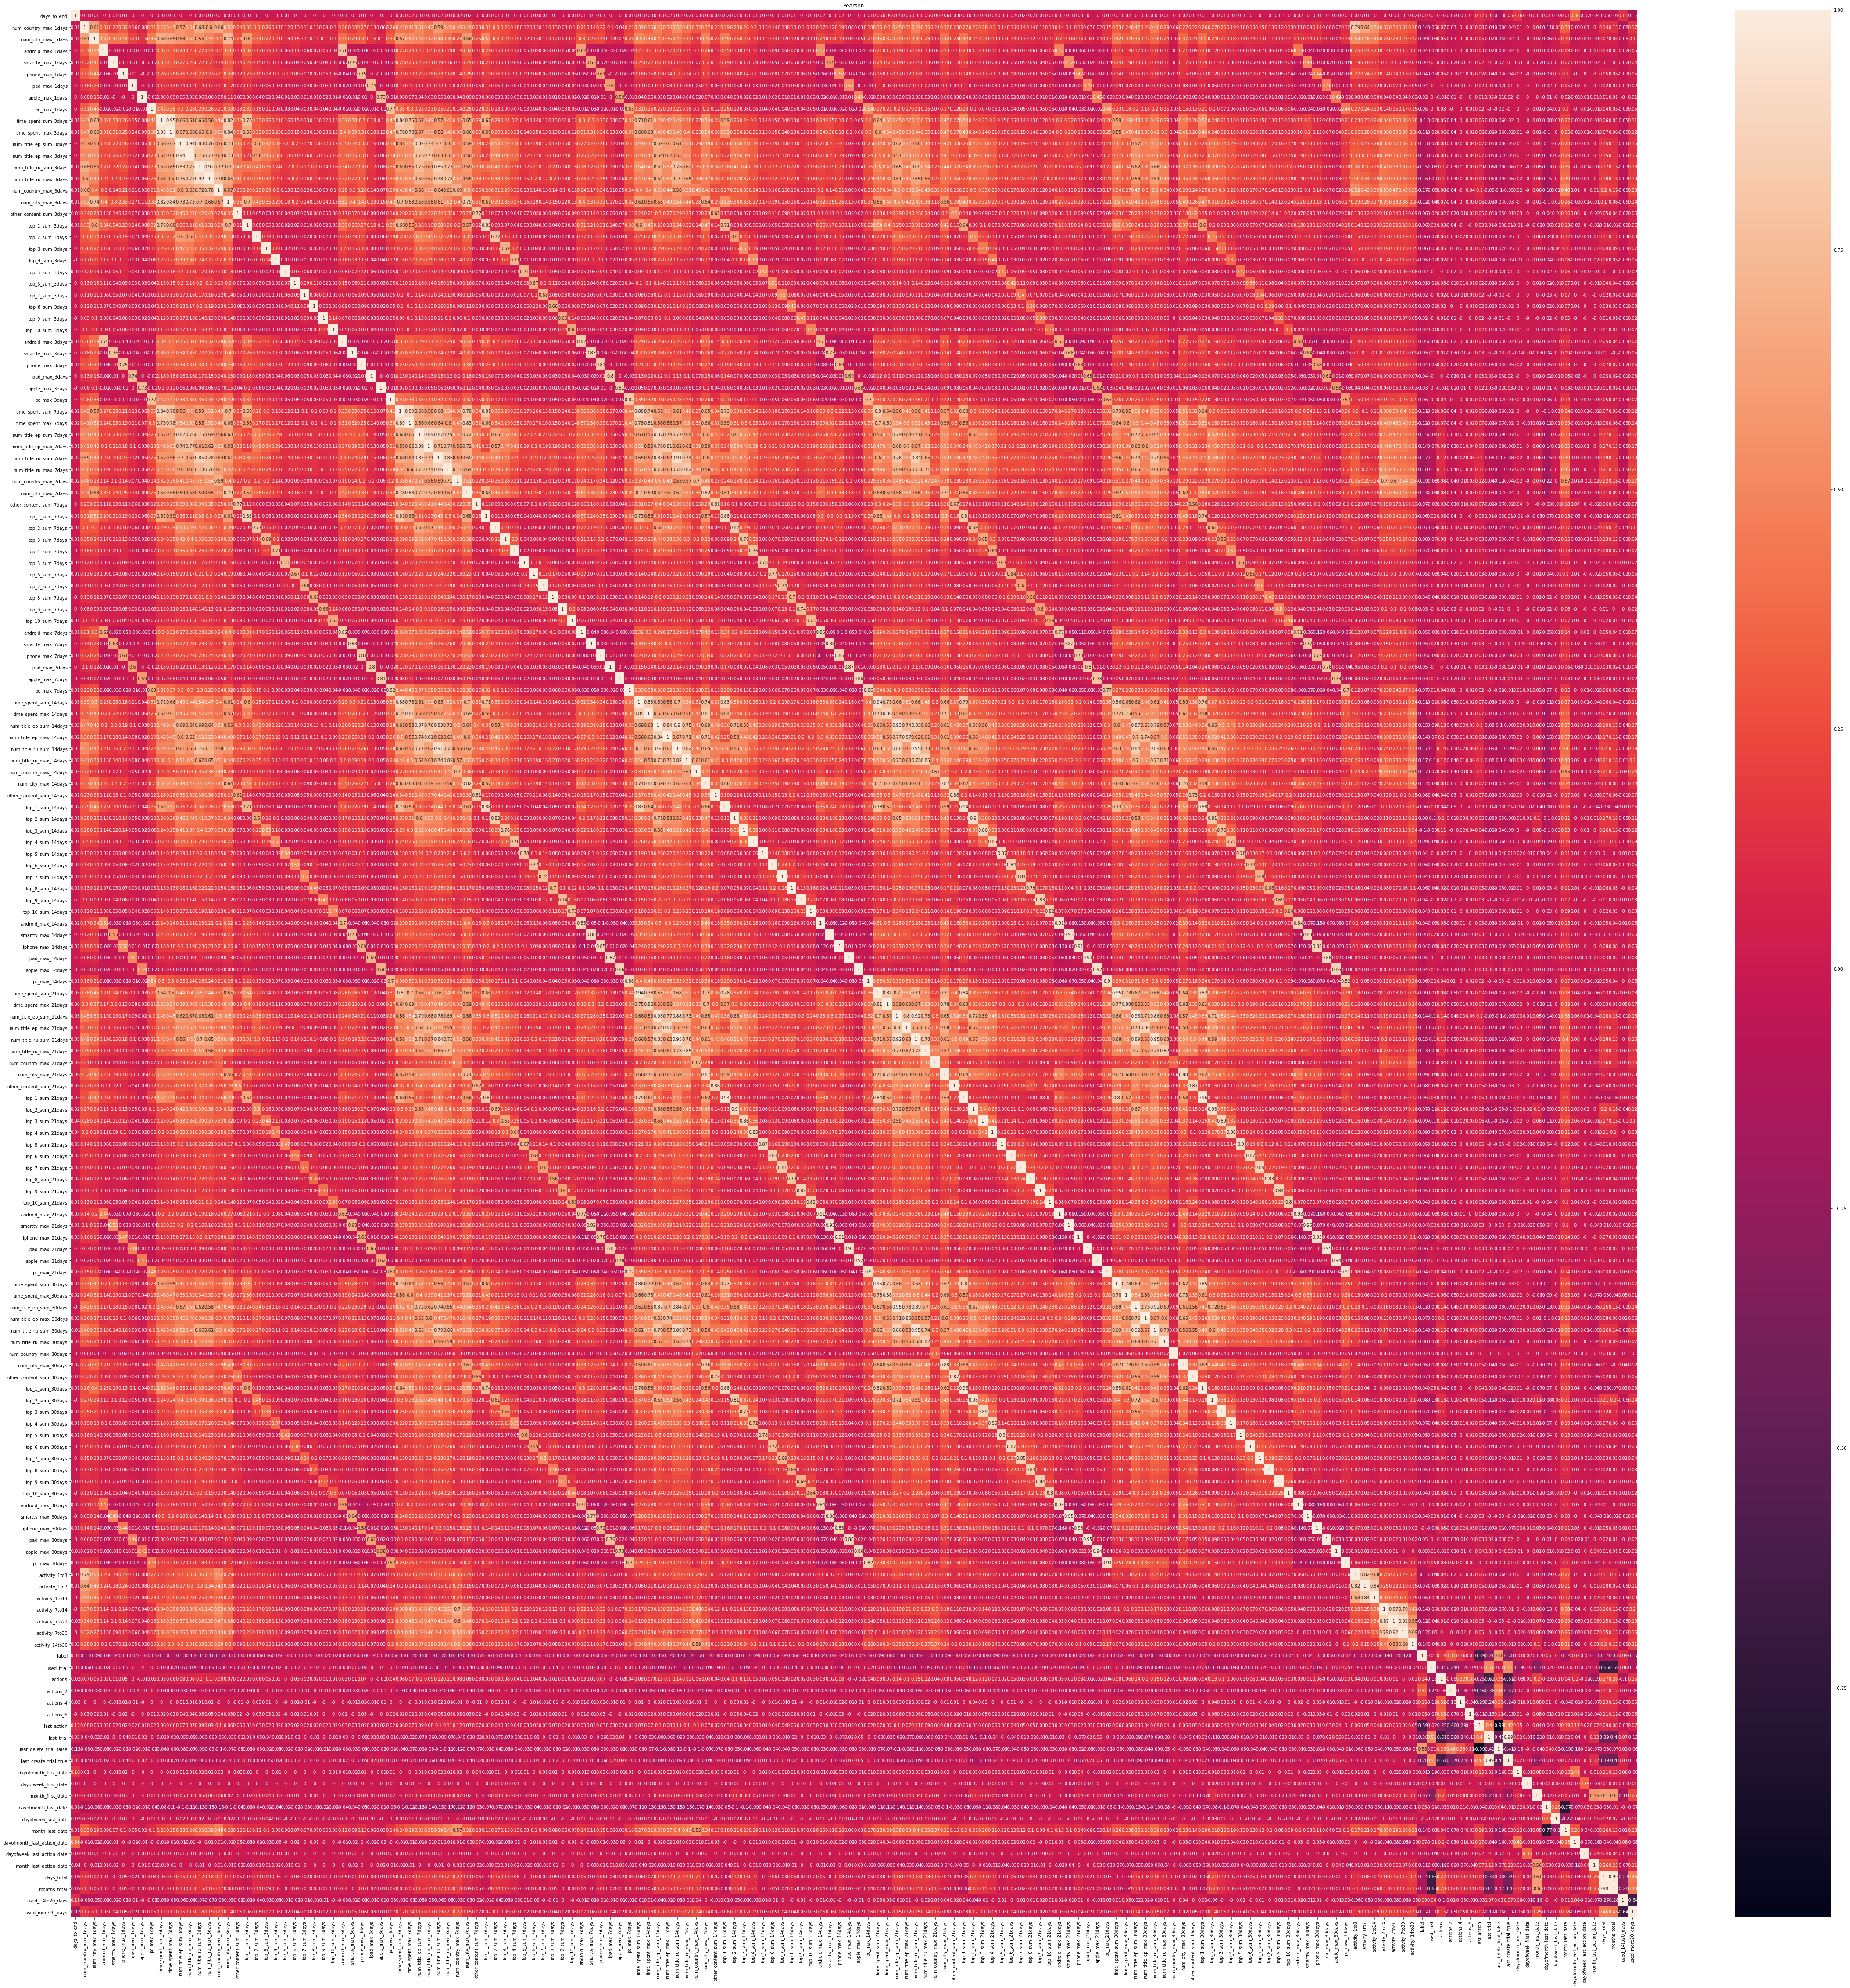

In [353]:
%%time

plt.subplots(figsize=(80, 80))
plt.title('Pearson')


corr_simple_res = round(X_train.corr(), 2)
sns.heatmap(corr_simple_res, annot=True);

<p>Open in new window to view.

## 3. Feature encoding and prototying with linear regression & random forest.
As not all of our features have numerical types, we must encode some of them. We will be using Label and Target encoding.<br> Next we will check how well our data works with linear regression and random forest.

In [255]:
cat_features = [i for i in X_train.columns if 'dayofmonth_' in i 
                or 'dayofweek_' in i or 'month_' in i or 'year_' in i] + ['email', 'last_action_date']

In [256]:
X_train_enc, X_test_enc = Label_Encoder(X_train.drop(['cut_date', 'first_date', 'last_date', 'label'], axis=1), 
                                X_test.drop(['cut_date', 'first_date', 'last_date'], axis=1), cat_features)

In [257]:
gc.collect()

20

In [136]:
skf_log = StratifiedKFold(n_splits=10, random_state=17, shuffle=True)
scores_log, coef = [], []
    
for train_idx, test_idx in skf_log.split(X_train_enc, y):
    
    X_training, y_training = X_train_enc.iloc[train_idx, :], y[train_idx]
    X_testing, y_testing = X_train_enc.iloc[test_idx, :], y[test_idx]
    
    
    logit = LogisticRegression(C = 0.1, max_iter=1000, solver='lbfgs',
                          random_state=17)
    logit_pipe = Pipeline([('scaler', StandardScaler()),
                      ('logit', logit)])
    
    logit_pipe.fit(X_training, y_training)
    logit_val_pred = logit_pipe.predict(X_testing)
    scores_log.append(roc_auc_score(y_testing, logit_val_pred))
    coef.append(logit_pipe.named_steps['logit'].coef_)
    
print(sum(scores_log)/len(scores_log))

0.7630754634828051


In [137]:
coefs = sum(coef)/len(coef)

In [138]:
pd.DataFrame(np.array(coefs).T, index = X_train_enc.columns, 
                           columns=['Coef']).sort_values(by='Coef', ascending=False)[:30]

Coef
month_last_date              1.010353
dayofmonth_last_date         0.663632
last_action_date             0.331015
dayofmonth_last_action_date  0.268679
last_trial                   0.252217
days_to_end                  0.221426
last_delete_trial_false      0.199676
top_2_sum_21days             0.161683
num_title_ep_sum_3days       0.146699
num_title_ru_max_30days      0.140089
num_title_ep_sum_7days       0.137826
num_city_max_21days          0.135337
android_max_30days           0.123657
apple_max_14days             0.122413
top_3_sum_30days             0.107532
top_5_sum_21days             0.100906
apple_max_7days              0.099925
time_spent_sum_3days         0.095058
iphone_max_30days            0.094084
dayofmonth_first_date        0.092237
other_content_sum_21days     0.091843
time_spent_sum_30days        0.090127
dayofweek_first_date         0.087664
time_spent_max_30days        0.086856
pc_max_30days                0.085574
time_spent_sum_21days        0.085293
activity_7to30               0.081440
num_title_ep_sum_14days      0.077693
months_total                 0.077209
num_country_max_30days       0.074202

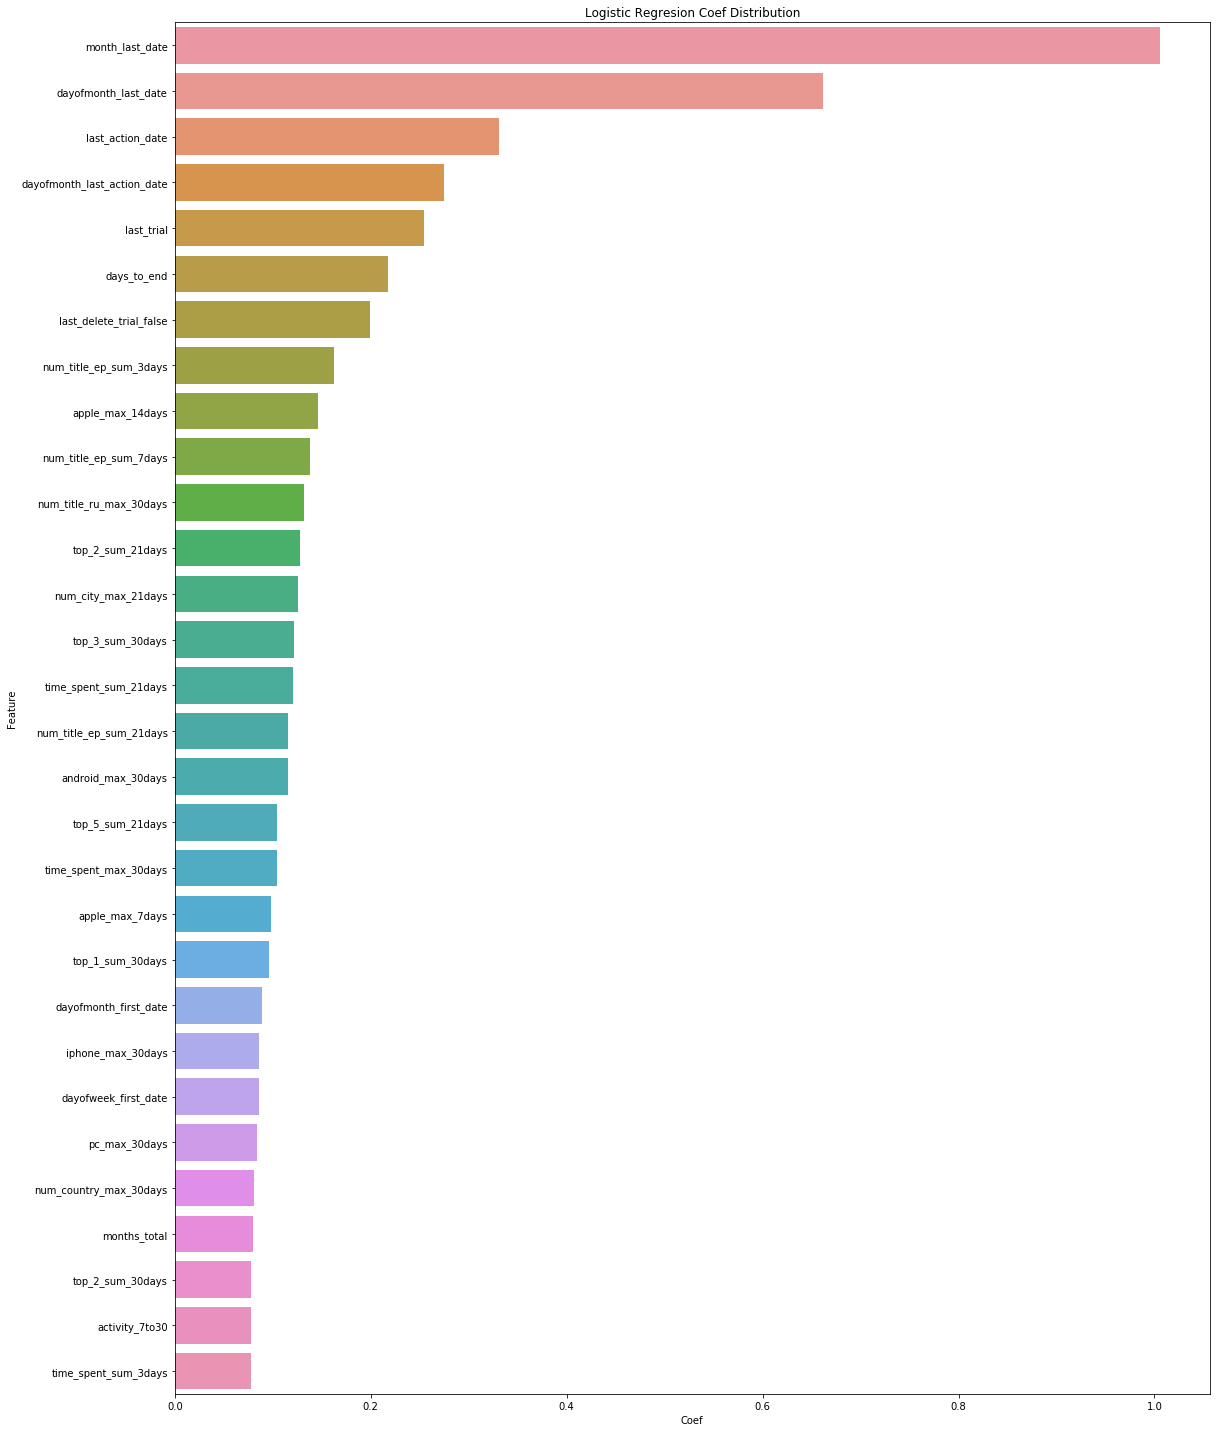

In [139]:
coef_imp = pd.DataFrame(sorted(zip(logit_pipe.named_steps['logit'].coef_.flatten(), X_train_enc.columns)), 
                           columns=['Coef', 'Feature'])

plt.figure(figsize=(17, 20))
sns.barplot(x="Coef", y="Feature", data=coef_imp.sort_values(by="Coef", ascending=False)[:30])
plt.title('Logistic Regresion Coef Distribution')
plt.tight_layout()
plt.show()

Lets try RandomForest before we strat with boosting:

In [262]:
X_training, X_testing, y_training, y_testing = train_test_split(X_train_enc, y, test_size=0.3, random_state=22)

scores, forest_importances = [], []

forest = RandomForestClassifier(n_estimators=300, max_depth=15,
                                random_state=17, n_jobs=-1, verbose=False)
forest.fit(X_training, y_training)
forest_val_pred = forest.predict(X_testing)
scores.append(roc_auc_score(y_testing, forest_val_pred))
forest_importances.append(forest.feature_importances_)
print(scores)

[0.8557337873823277]


Looks well, lets check feature importances:

In [263]:
pd.DataFrame(sum(forest_importances)/len(forest_importances), index = X_training.columns, 
                           columns=['Importance']).sort_values(by='Importance', ascending=False)

Importance
last_action                    0.139425
last_delete_trial_false        0.138607
last_action_date               0.096168
dayofmonth_last_action_date    0.038206
actions                        0.029154
...                                 ...
apple_max_7days                0.000149
top_9_sum_3days                0.000136
ipad_max_1days                 0.000115
apple_max_3days                0.000070
apple_max_1days                0.000025

[165 rows x 1 columns]

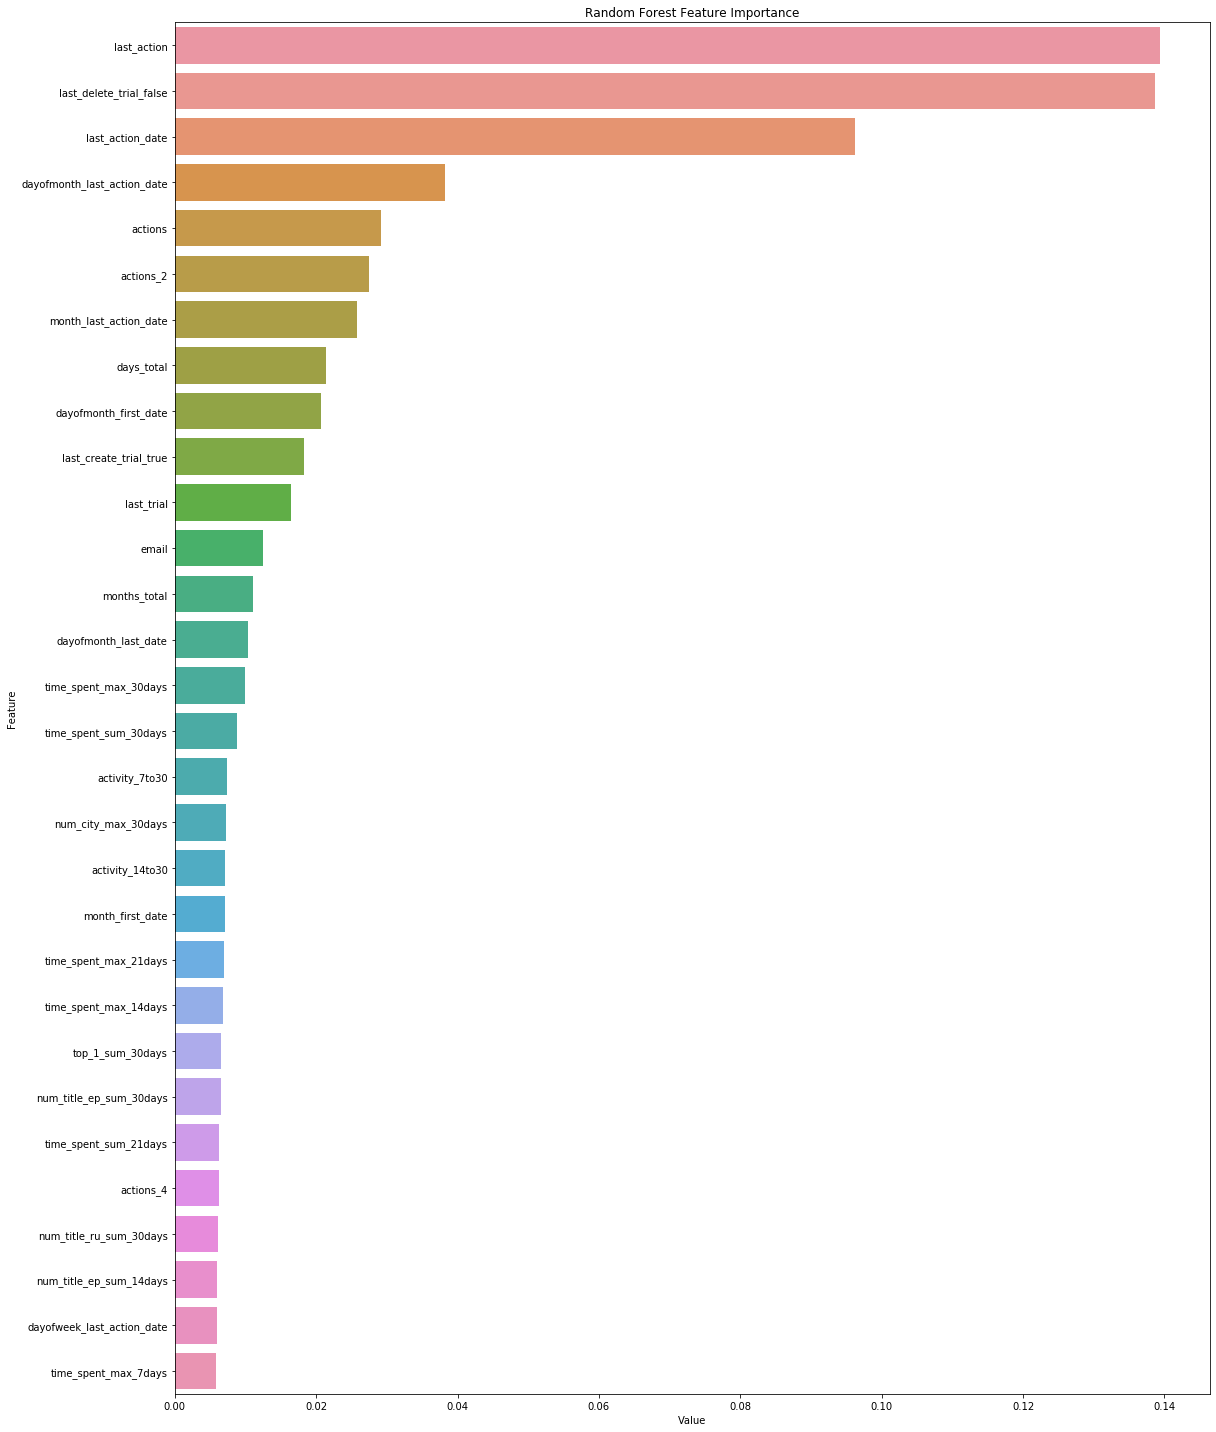

In [264]:
feature_imp = pd.DataFrame(sorted(zip(sum(forest_importances)/len(forest_importances), X_training.columns)), 
                           columns=['Value', 'Feature'])

plt.figure(figsize=(17, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:30])
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

And finally, we get to boosting. First we'll tune our parameters using Bayesian Optimization:

In [294]:
X_training, X_testing, y_training, y_testing = train_test_split(X_train_enc, y, test_size=0.3, random_state=28)

In [318]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, 
                            n_folds=4, random_seed=6, n_estimators=1000, 
                            learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, categorical_feature=None, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, 
                 max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        
        params = {'application':'binary',
                  'num_iterations': n_estimators, 
                  'learning_rate':learning_rate, 
                  'early_stopping_round':100, 
                  'metric':'auc'}
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, 
                           seed=random_seed, stratified=True, 
                           verbose_eval =200, metrics=['auc'])
        
        return max(cv_result['auc-mean'])
    
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {
                                            'num_leaves': (5, 35),
                                            'feature_fraction': (0.5, 0.99),
                                            'bagging_fraction': (0.8, 0.99),
                                            'max_depth': (4, 15),
                                            'lambda_l1': (0, 3),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 55)}, random_state=6)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # return best parameters
    return lgbBO.res

In [319]:
opt_params = bayes_parameter_opt_lgb(X_training, y_training, init_round=5, opt_round=10, n_folds=4, random_seed=24)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[200]	cv_agg's auc: 0.925327 + 0.00148781
[400]	cv_agg's auc: 0.938028 + 0.00182671
[600]	cv_agg's auc: 0.947692 + 0.00171375
[800]	cv_agg's auc: 0.954844 + 0.00175077
[1000]	cv_agg's auc: 0.960506 + 0.0016936
|  1        |  0.9605   |  0.9696   |  0.6627   |  2.464    |  0.1251   |  5.184    |  34.75    |  0.05345  |  17.56    |
[200]	cv_agg's auc: 0.944042 + 0.00174391
[400]	cv_agg's auc: 0.962213 + 0.00190169
[600]	cv_agg's auc: 0.972462 + 0.00162868
[800]	cv_agg's auc: 0.979011 + 0.00156515
[1000]	cv_agg's auc: 0.98333 + 0.00142046
|  2        |  0.9833   |  0.8637   |  0.805    |  1.314    |  2.208    |  9.698    |  33.94    |  0.06489  |  34.71    |
[200]	cv_agg's auc: 0.927143 + 0.0021352
[400]	cv_agg's auc: 0.940808 + 0.00211
[600]	cv_agg

In [322]:
params = opt_params4[8]['params']
params ['num_leaves'] = int(params4['num_leaves'])
params ['max_depth'] = int(params4['max_depth'])

Finally, we will use KFold with our params:

In [326]:
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train_enc.shape[0])
sub_preds = np.zeros(X_test_enc.shape[0])
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train_enc)):
    trn_x, trn_y = X_train_enc.iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = X_train_enc.iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        **params,
        application='binary',
        early_stopping_round=100, 
        n_estimators=1000,
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=250, early_stopping_rounds=150
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(X_test_enc, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    
    if n_fold == 4:
        clf_shap = clf
    
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))

Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.984206	training's binary_logloss: 0.179406	valid_1's auc: 0.976095	valid_1's binary_logloss: 0.197252
[500]	training's auc: 0.996866	training's binary_logloss: 0.115204	valid_1's auc: 0.991848	valid_1's binary_logloss: 0.137738
[750]	training's auc: 0.999194	training's binary_logloss: 0.0795409	valid_1's auc: 0.996086	valid_1's binary_logloss: 0.103087
[1000]	training's auc: 0.999755	training's binary_logloss: 0.055921	valid_1's auc: 0.997472	valid_1's binary_logloss: 0.079442
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.999755	training's binary_logloss: 0.055921	valid_1's auc: 0.997472	valid_1's binary_logloss: 0.079442
Fold  1 AUC : 0.997472
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.983911	training's binary_logloss: 0.17954	valid_1's auc: 0.975502	valid_1's binary_logloss: 0.199353
[500]	training's auc: 0.996916	training's binar

Some feature explanations with shap:

In [340]:
%%time
explainer = shap.TreeExplainer(clf_shap)
shap_values = explainer.shap_values(X_test_enc)

Wall time: 22.4 s


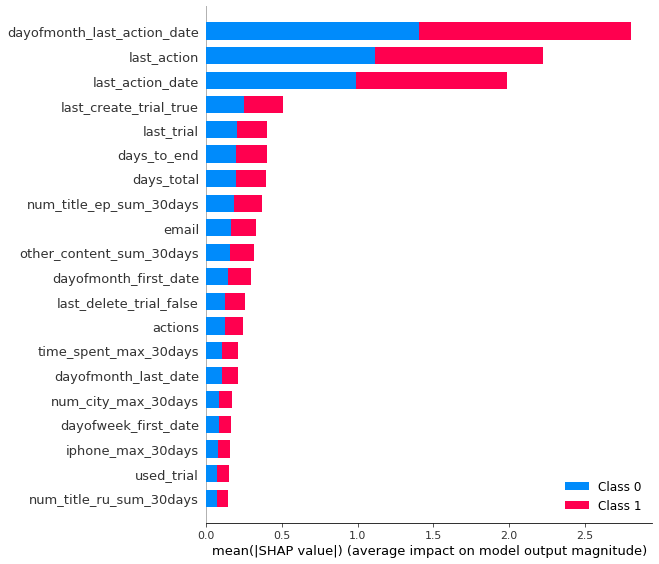

In [341]:
shap.summary_plot(shap_values, X_test_enc)

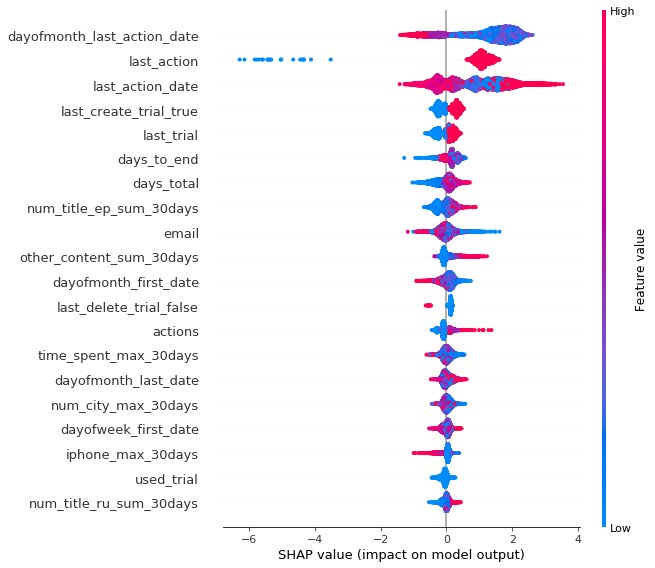

In [348]:
shap.summary_plot(shap_values[0], X_test_enc, plot_type='dot')

In [363]:
test['prediction'] = sub_preds
test[['email', 'prediction']].to_csv('submission.csv', index=False, float_format='%.8f')